# 07 Raster2 Exercises
## Reprojection, Clipping, Sampling, Zonal Stats

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## ⚠️ Suggestion - shut down other unneeded kernels before running

In [ ]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
import rioxarray
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
#%matplotlib widget

## Part 0: Prepare DEM data
* Run the Jupyterbook demo notebook to query and download data (07_Raster2_DEMs_Warp_Clip_Sample_demo.ipynb)
* Update the `dem_data` path to the corresponding subdirectory in the jupyterbook repo

In [ ]:
dem_data = '/home/jovyan/jupyterbook/book/modules/07_Raster2_DEMs_Warp_Clip_Sample/dem_data'

In [ ]:
#We will use the Washington state 3-arcsec SRTM dataset for these exercises
dem_fn = os.path.join(dem_data, "WA_SRTMGL3.tif")
#dem_fn = os.path.join(dem_data, "WA_COP90.tif")

### Reproject the WA DEM data using gdalwarp or rasterio
* See demo
* Output should be LZW compressed and Tiled

In [ ]:
#Define desired CRS for output
dst_crs = 'EPSG:32610'

In [ ]:
#Student Exercise

### Open as rasterio dataset
* Store as `src_proj` variable
* Check profile and CRS to make sure things look good

In [ ]:
#Student Exercise

### Create a shaded relief map for the projected DEM
* See demo

In [ ]:
#Student Exercise

### Load as masked array with rasterio

In [ ]:
#Student Exercise

In [ ]:
hs_extent = rio.plot.plotting_extent(hs_src)

### Load the states GeoDataFrame

In [ ]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
#Reproject to match raster
states_gdf_proj = states_gdf.to_crs(src_proj.crs)
#Isolate WA state
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']
#Extract geometry to use for clipping
wa_geom = wa_state.iloc[0].geometry

### Clip to WA state
* See demo
* Store output array and transform from `rio.mask.mask` as `wa_ma` and `wa_ma_transform`
* https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html

In [ ]:
#Pass this in to the `rio.mask.mask` call (see demo)
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}

In [ ]:
#Student Exercise

* Determine the clipped extent for imshow in the projected CRS using the `rio.plot.plotting_extent`

In [ ]:
#Student Exercise

(371115.31896165153, 971151.8939989337, 5043526.21288473, 5444604.739324637)

## Part 1: DEM Visualization and Analysis

### Create a color shaded relief map
* You should already have the projected, clipped DEM and the hillshade (from unclipped, projected DEM) loaded as arrays
* Create a plot overlaying color elevation values on the hillshade
    * It's important to correctly set the `extent` for each of the two arrays when passing to `imshow`, otherwise they won't line up correctly. We did this in Lab05.
    * Use imshow `alpha` to set transparency of the DEM
    * Add a colorbar

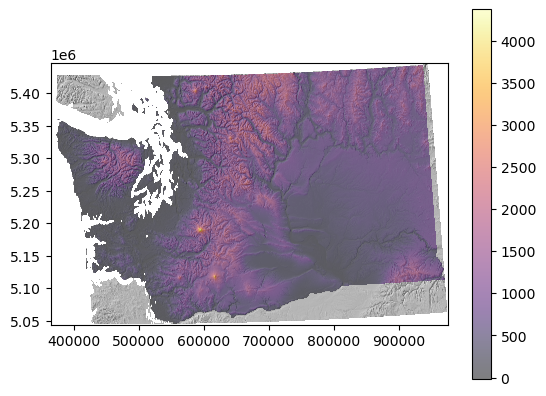

In [ ]:
#Student Exercise

### What is the maximum elevation in WA state
* According to your clipped DEM, not google :)

In [ ]:
#Student Exercise

#### Extra Credit: What percentage of the state is >1 mile above sea level? 
* Sorry about the imperial units, but this is what matters to your average hiking enthusiast
* Think back to Lab05 and the NDSI threshold appraoch to determine snow-covered area
* Remember, that you have a regular grid here, so you know the dimensions in meters of each grid cell
* As we know, this kind of calculation should be done in an equal-area projection, but fine to estimate with UTM projection here

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

## Part 2: Volume estimation
* In the Raster 1 lab, we computed snow-covered area from a 2D array with known pixel dimensions (30x30 m for Landsat-8)
* Now, let's add a third dimension to compute volume from a 2D array of elevation values
    * Imagine dividing the domain up into 1 cubic meter blocks - your elevation values are like stacks of these 1-m cubes above some reference datum
* Volume (and volume change) calculations are common operations with gridded DEMs.  The analysis is often referred to as "cut/fill". For example:
    * Measuring quarry slag pile volume
    * Measuring ice sheet and glacier change
* Let's start with a simple example

### Compute the volume of Whidbey Island above sea level
* First, we need an area over which to compute volume
* Extract the Whidbey Island polygon from the WA state geometry

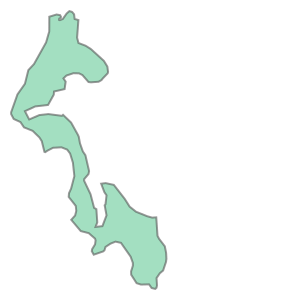

In [ ]:
#If using the 500k state outlines, Whidbey is at index 7 in the MultiPolygon
whidbey_geom = wa_geom.geoms[7]
whidbey_geom

In [ ]:
#Define a GeoSeries for easy plotting using GeoPandas
whidbey_gdf = gpd.GeoSeries(whidbey_geom)
whidbey_gdf

0    POLYGON ((535640.328 5348457.490, 535403.340 5...
dtype: geometry

* Now, mask the projected DEM dataset using this geometry
    * Note, `rio.mask.mask` expects an iterable "shape", not a single geometry, so need to create and pass a single-element list object containing the whidbey_geom (something like `[whidbey_geom,]`)
    * Use the same parameters that we used when clipping to the WA state geometry above

In [ ]:
whidbey_ma, whidbey_out_transform = rio.mask.mask(src_proj, [whidbey_geom,], **rio_mask_kwargs)
whidbey_ma_extent = rio.plot.plotting_extent(whidbey_ma, whidbey_out_transform)

In [ ]:
whidbey_ma_extent

(517068.30347175116, 548623.8474614524, 5305801.594847063, 5362175.333565047)

### Create a plot of clipped Whidbey DEM
* Verify that you have a masked array of elevation values, with unmasked values only over the Whidbey polygon
* Extra credit: add hillshade, colorbar and scalebar

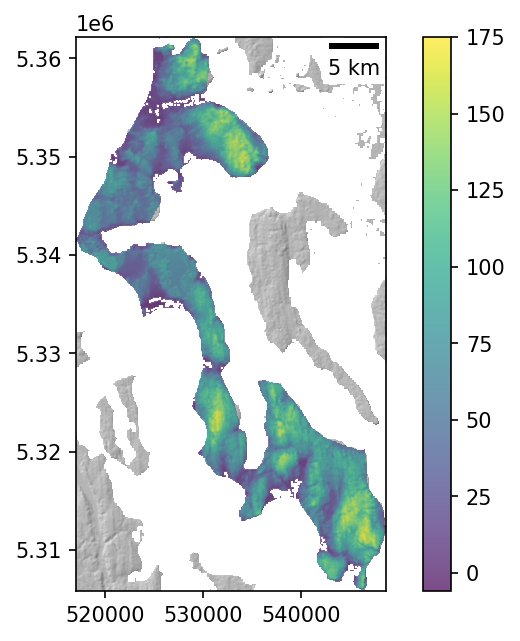

In [ ]:
#Student Exercise

#### Define a "bottom" surface for our volume calculation
* Let's use a constant elevation above the geoid (mean sea level) as our "baseline" elevation
    * Since our DEM values are height above the EGM96 geoid, we can use 0 here
    * Note that this bottom surface can also be more complex: a planar fit to elevations around a polygon, lake bathymetry, etc.

In [ ]:
#Student Exercise

### Compute the volume
* Compute the height of the DEM above this "baseline" elevation
* Convert the total volume to km^3
* Two potential methods:
    1. Use the known pixel size (remember `res` attribute of projected rasterio dataset) to compute the area of each pixel in m^2, then multiply by the height in m
    2. Determine mean height above the "baseline" elevation and multiply by total polygon area
* Try to do a sanity check here

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

Volume estimate, method 1: 28.61 km3
Volume estimate, method 2: 29.47 km3


Note: The volume estimates from the two approaches are slightly different because the 500K polygon geometry is not quite the same as the mask that the DEM creators used to mask water.  You can see this in the figure above, note areas with hillshade pixels but no color overlay.

### We're gonna need a bigger boat...
* Sea level rise is very real
    * Current global average rates are ~3.6 mm/yr
    * This may not sound like much, but over 100 years, thats 36 cm or ~1.2 feet! And the rate is increasing nonlinearly.
    * Some good references:
        * U.S. Interagency report from 2022: https://oceanservice.noaa.gov/hazards/sealevelrise/sealevelrise-tech-report.html
        * https://www.ipcc.ch/srocc/chapter/chapter-4-sea-level-rise-and-implications-for-low-lying-islands-coasts-and-communities/
        * https://archive.ipcc.ch/publications_and_data/ar4/wg1/en/faq-5-1.html
        * https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter13_FINAL.pdf
        * http://www.antarcticglaciers.org/glaciers-and-climate/what-is-the-global-volume-of-land-ice-and-how-is-it-changing/
* Let's do some rough inundation calculations using our DEM
    * Note that in practice, we wouldn't use a global DEM product like SRTM or COP30 for this, but would use a very accurate airborne lidar datset (like the most recent lidar data available from USGS 3DEP or WA DNR)
    * There are many other caveats here, as sea level rise is much more complex than just "filling the bathtub" (see the IPCC report), but we're learning concepts and techniques, so let's start with a simple case.

#### Create a function to compute the area and volume of whidbey island above sea level for:
* 1 meter of sea level rise
* 10 meters of sea level rise
* 20 meters of sea level rise
* 66 meters of sea level rise (roughly the total if all land ice melted, without accounting for thermal expansion)

#### Add a visualization component to your function
* Create plots using the whidbey Polygon as "reference shoreline", and plot valid DEM values above the sea level with fixed color ramp limits
* Extra credit: add notation for area and volume above sea level

In [ ]:
#def slr_plot(dem_ma, sl=0):

In [ ]:
#Student Exercise

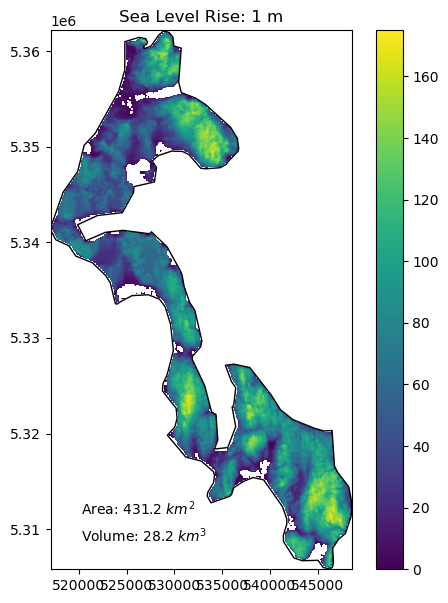

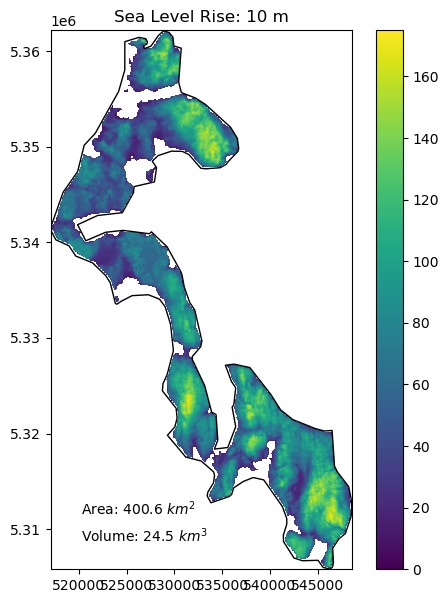

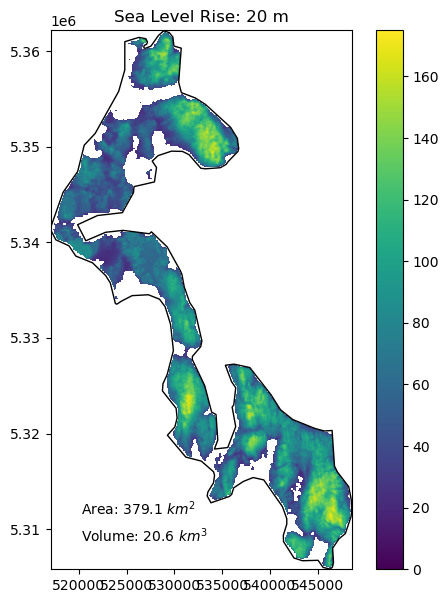

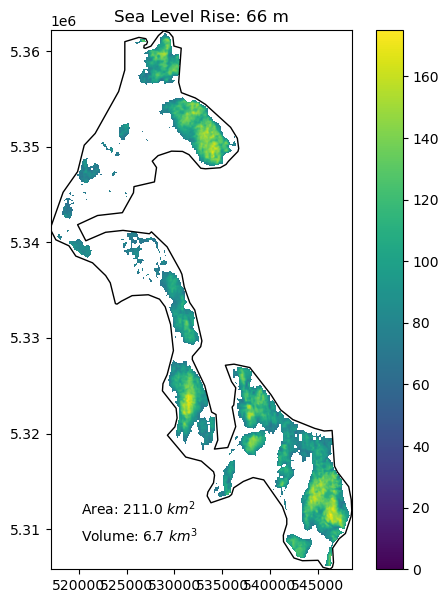

In [ ]:
slr_values = (1,10,20,66)
for i in slr_values:
    slr_plot(whidbey_ma, sl=i)

### Extra Credit: Create area and volume inundation curves
* Starting with sea level of 0, increase by 1 m increments until Whidbey is totally submerged
* Create plots for:
    * exposed area vs sea level
    * exposed volume vs sea level
* Are the curves linear?  

In [ ]:
#Student Exercise

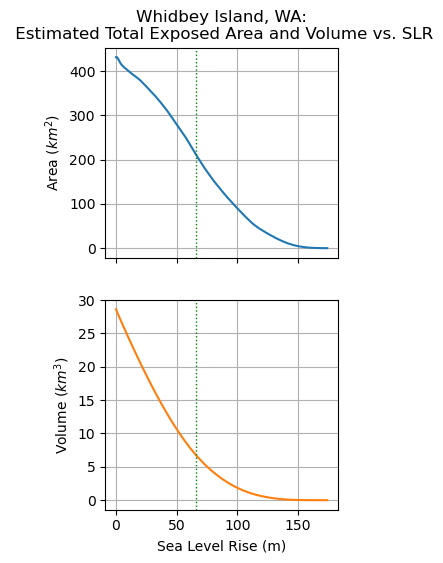

In [ ]:
#Student Exercise

## Part 3: Sampling a raster at points

Say you have some point data (e.g., lat/lon of field sites) and you need elevation values for your anlysis.  Do you need to go back out and collect new GPS positions?  No!  You can extract elevation values from an existing DEM!

This is a surprisingly common requirement, though it is not always simple to implement.  Let's discuss a few options:
1. Simple `rasterio` sampling with integer indices using value from nearest raster cell (nearest neighbor)
2. Interpolated elevation from nearby pixels (e.g., bilinear interpolation)
3. Statistics extracted for a circular buffer around each point location (e.g., median for all pixels within 90 m radius of the point)

### Sample the clipped WA DEM at the WA GLAS points
* Let's start simple, using the rasterio `sample` function, which takes a list of (x,y) tuples in projected coordinates and returns nearest neighbor values from the raster

#### Load the GLAS points, reproject and clip to WA state
* We did all of this in previous labs, so I'm including sample code here

In [ ]:
#Define path to the GLAS csv file
glas_fn = '~/jupyterbook/book/modules/01_Shell_Github/data/GLAH14_tllz_conus_lulcfilt_demfilt.csv'

In [ ]:
#Prepare geodataframe
glas_df = pd.read_csv(glas_fn)
glas_gdf = gpd.GeoDataFrame(glas_df, crs='EPSG:4326', geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']))

#Reproject to match our raster crs
glas_gdf_utm = glas_gdf.to_crs(src_proj.crs)

#Return points that intersect WA state geometry
glas_gdf_utm_wa = glas_gdf_utm.loc[glas_gdf_utm.intersects(wa_geom)]
glas_gdf_utm_wa.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
467,2003.143756,731268.470838,46.291775,-124.037745,-23.44,-23.53,0.00,31,POINT (420068.610 5126989.811)
468,2003.143756,731268.470838,46.293329,-124.038072,-23.11,-23.54,0.00,31,POINT (420045.685 5127162.809)
469,2003.143756,731268.470838,46.294880,-124.038399,-23.98,-22.78,0.26,31,POINT (420022.757 5127335.473)
470,2003.143756,731268.470840,46.302568,-124.040034,-24.61,-23.72,0.11,31,POINT (419908.041 5128191.352)
471,2003.143756,731268.470840,46.304107,-124.040358,-23.92,-23.73,0.00,31,POINT (419885.336 5128362.681)


#### Prepare the coordinate arrays to pass to rio `sample` function
* We touched on this in 05 demo and Lab05 when exploring the geotransform, corner coordinates and extracting values from the NumPy array. Maybe consult the demo, your code and/or the solutions.
    * https://uwgda-jupyterbook.readthedocs.io/en/latest/modules/05_Raster1_GDAL_rasterio_LS8/05_Raster1_GDAL_rasterio_demo.html#raster-and-array-sampling
    * The GeoPandas doc also has a simple example: https://geopandas.org/en/stable/gallery/geopandas_rasterio_sample.html
* The `sample` function expects a list of (x,y) tuples: https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
    * Need to create this list of tuples from the Point geometry objects in your GeoDataFrame
    * Hint: Use list comprehension!
    * You want a list of the form [(x1,y1),(x2,y2),…]
* Pass to `sample`
* Note that the `sample` function returns a `generator` object, and it doesn't actually evaluate the call!
* Can wrap the returned generator object in a `np.array(list())` to evaluate, or use `np.fromiter()`
* This operation may take ~10-20 seconds to complete

I included some sample output for the first 10 records to make sure you're on the right track.

In [ ]:
#Student Exercise

First 10 records...


[(420068.6096560212, 5126989.811026542),
 (420045.6845556927, 5127162.808572696),
 (420022.756572206, 5127335.47293138),
 (419908.0411685074, 5128191.352440438),
 (419885.33555505634, 5128362.681306876),
 (410564.59385410615, 5197909.486655028),
 (410541.06220828043, 5198082.008111783),
 (410517.52547154634, 5198254.085230813),
 (401004.50357059937, 5269865.468511085),
 (400982.6047505999, 5270037.926469663)]

In [ ]:
len(glas_coord)

5298

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

First 10 records...


array([  0,   0,   0,   0,   1,   0,   0,   4,  91, 132], dtype=int16)

#### Deal with nodata
* Some of our GLAS points are located over areas where we don't have valid elevation measurements in the DEM
* These will have the raster nodata value (e.g., 0 in the SRTM-GL1 products)
* Set these to `np.nan`

In [ ]:
#Check raster dataset nodata value
src_proj.nodata

0.0

In [ ]:
#Need to convert to float here, as DEM samples are int16 and np.nan is float
glas_dem_elev = glas_dem_elev.astype(float)
glas_dem_elev[glas_dem_elev == src_proj.nodata] = np.nan
#glas_dem_elev = np.ma.masked_equal(glas_dem_elev, src_proj.nodata)

### Store the sampled elevation values as a new column in the `glas_gdf_utm_wa` GeoDataFrame

In [ ]:
glas_gdf_utm_wa['dem_rio_sample'] = glas_dem_elev
glas_gdf_utm_wa.head()

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry,dem_rio_sample
467,2003.143756,731268.470838,46.291775,-124.037745,-23.44,-23.53,0.00,31,POINT (420068.610 5126989.811),NaN
468,2003.143756,731268.470838,46.293329,-124.038072,-23.11,-23.54,0.00,31,POINT (420045.685 5127162.809),NaN
469,2003.143756,731268.470838,46.294880,-124.038399,-23.98,-22.78,0.26,31,POINT (420022.757 5127335.473),NaN
470,2003.143756,731268.470840,46.302568,-124.040034,-24.61,-23.72,0.11,31,POINT (419908.041 5128191.352),NaN
471,2003.143756,731268.470840,46.304107,-124.040358,-23.92,-23.73,0.00,31,POINT (419885.336 5128362.681),1.0


#### Create a plot of your new sampled elevation values
* Can visualize over shaded relief map or DEM
* Optional: include a subplot with GLAS values with same color scale

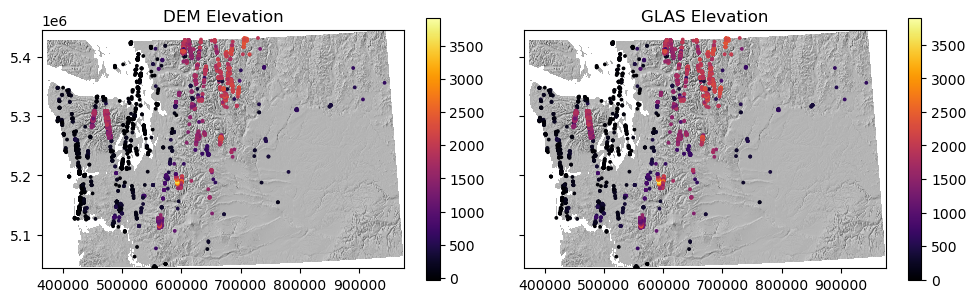

In [ ]:
#Student Exercise

### Extra Credit: Compare sampled DEM elevation with the GLAS elevation (`glas_z`)

In [ ]:
glas_gdf_utm_wa['glas_dem_diff'] = glas_gdf_utm_wa['glas_z'] - glas_gdf_utm_wa['dem_rio_sample']

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### What is median offset?
* Think back to Lab03 where we learned about datums and elevations reported as height above ellipsoid vs. height above geoid (mean sea level)

In [ ]:
glas_gdf_utm_wa['glas_dem_diff'].median()

-20.700000000000045

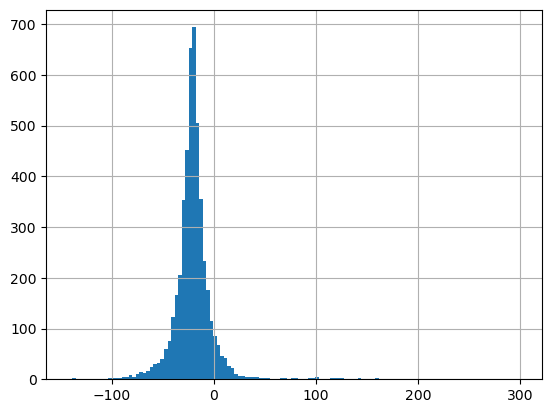

In [ ]:
glas_gdf_utm_wa['glas_dem_diff'].hist(bins=128);

#### Prepare EGM96 geoid offset grid

In [ ]:
#From PROJ7 cloud-hosted datum grids: https://cdn.proj.org/
url = 'https://cdn.proj.org/us_nga_egm96_15.tif'

In [ ]:
src_egm96 = rio.open(url)
src_egm96.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_epsg(4979), 'transform': Affine(0.25, 0.0, -180.125,
       0.0, -0.25, 90.125), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [ ]:
egm96 = src_egm96.read(1)
egm96_extent = rio.plot.plotting_extent(src_egm96)
np.percentile(egm96, (2,98))

array([-60.25124443,  59.33671082])

#### Prepare EGM96 offset grid figure

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
clim = (-60,60)
#Contour interval
cint = 10
clevels=np.arange(np.floor(egm96.min()/cint)*cint, np.ceil(egm96.max()/cint)*cint, cint)

In [ ]:
#This function is defined later in the notebook
#egm96_hs,_,_ = hillshade(egm96)

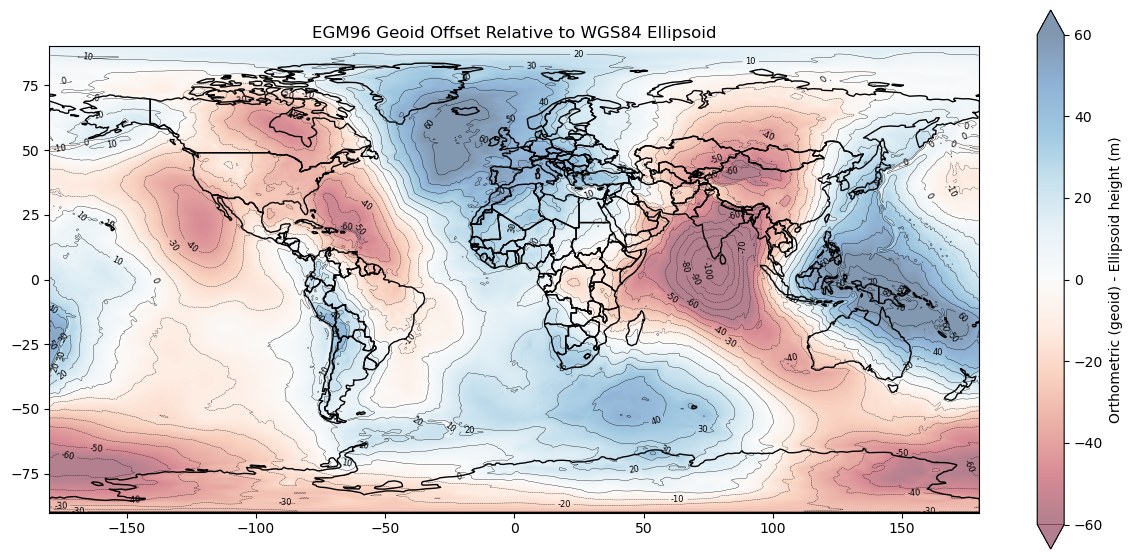

In [ ]:
f, ax = plt.subplots(figsize=(15,7))
m = ax.imshow(egm96, extent=egm96_extent, cmap='RdBu', clim=clim, alpha=0.5, zorder=1)
#ax.imshow(egm96_hs, cmap='gray', extent=egm96_extent, zorder=0)
ax.autoscale(False)
c_color = 'k'
cs = ax.contour(egm96, origin='image', extent=egm96_extent, linewidths=0.25, alpha=1.0, colors=c_color, levels=clevels)
ax.clabel(cs, inline=1, fmt='%0.0f', colors=c_color, fontsize=6)
world.plot(ax=ax, facecolor='none', lw=1, edgecolor='k', zorder=2)
plt.colorbar(m, label='Orthometric (geoid) - Ellipsoid height (m)', extend='both');
ax.set_title('EGM96 Geoid Offset Relative to WGS84 Ellipsoid');

TODO: warp egm96 offset grid to match the reprojected DEM grid, then sample

#### Sample the EGM96 offset grid at GLAS points

In [ ]:
#Prepare (lon, lat) tuples
glas_coord_latlon = list(zip(glas_gdf_utm_wa['lon'], glas_gdf_utm_wa['lat']))

In [ ]:
glas_dem_elev_offset = np.fromiter(src_egm96.sample(glas_coord_latlon), dtype=egm96.dtype)

In [ ]:
glas_dem_elev_offset

array([-23.04253 , -23.04253 , -23.04253 , ..., -23.190092, -23.190092,
       -23.190092], dtype=float32)

In [ ]:
#Add the offset to the EGM96 elevations to obtain elevations relative to ellipsoid
glas_gdf_utm_wa['dem_rio_sample_HAE'] = glas_gdf_utm_wa['dem_rio_sample'] + glas_dem_elev_offset

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
#Compare new elevations with GLAS elevations
glas_gdf_utm_wa['glas_dem_diff_HAE'] = glas_gdf_utm_wa['glas_z'] - glas_gdf_utm_wa['dem_rio_sample_HAE']

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
glas_gdf_utm_wa['glas_dem_diff_HAE'].median()

-0.8203044891356512

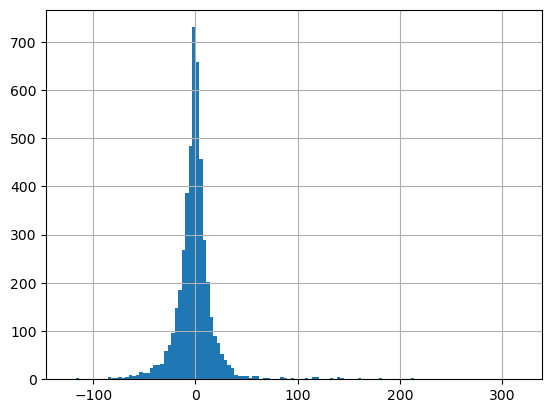

In [ ]:
glas_gdf_utm_wa['glas_dem_diff_HAE'].hist(bins=128);

Not perfect agreement (median bias due to different input raster resolution/projection for DEM grid and EGM96 grid, plus nearest neighbor sampling), but at least we're comparing apples to apples, with both elevations representing height above ellipsoid

### Notes on sampling coarse rasters or noisy rasters at integer pixel locations
* The rasterio approach is efficient, but it uses "nearest neighbor" approach to extract the elevation value for the grid cell that contains the point, regradless of where the point falls within the grid cell (center vs. corner)
* But our grid cells can be big (~90x90 m for the global DEM data used here), so if point is near the corner of a pixel on steep slope, the pixel value it might not be representative.
* A better approach is to use bilinear or bicubic sampling, to interpolate the elevation value at the point coordinate using pixel values within some neighborhood around the point, (e.g. 2x2 window for bilinear, 4x4 window for cubic)
* Other approaches using stats for raster values within some radius of the point location (e.g., median elevation of pixels within 300 m of the point)
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/
    * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html#getting-values-at-cells
    * https://github.com/uw-cryo/raster_sampling

### Extra Credit: Compute stats for circular buffer polygon around each GLAS point using Zonal Statistics 
* Buffer with width of 3x the DEM resolution (in meters) and compare with the nearest neighbor values from rasterio `sample` above

In [ ]:
buff_width = src_proj.res[0]*3
buff_width

206.24538555360294

In [ ]:
#Create new GeoDataSeries of buffered polygons
glas_gdf_utm_wa_buff = glas_gdf_utm_wa.buffer(buff_width)
glas_gdf_utm_wa_buff

467      POLYGON ((420274.855 5126989.811, 420273.862 5...
468      POLYGON ((420251.930 5127162.809, 420250.937 5...
469      POLYGON ((420229.002 5127335.473, 420228.009 5...
470      POLYGON ((420114.287 5128191.352, 420113.293 5...
471      POLYGON ((420091.581 5128362.681, 420090.588 5...
                               ...                        
65068    POLYGON ((426378.231 5138031.192, 426377.238 5...
65069    POLYGON ((426350.848 5137859.495, 426349.855 5...
65070    POLYGON ((426295.694 5137516.106, 426294.701 5...
65071    POLYGON ((426267.999 5137344.413, 426267.006 5...
65072    POLYGON ((426240.302 5137172.610, 426239.309 5...
Length: 5298, dtype: geometry

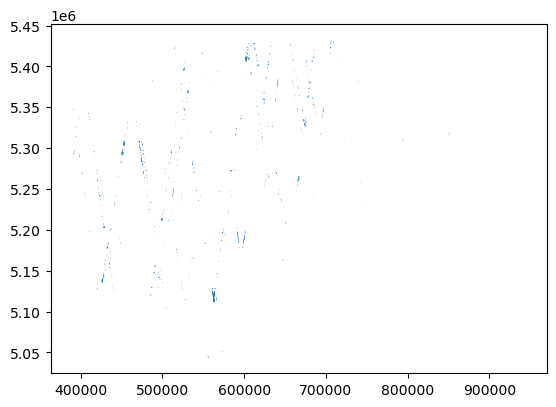

In [ ]:
ax = glas_gdf_utm_wa_buff.plot()

(5174595.0, 5205315.0)

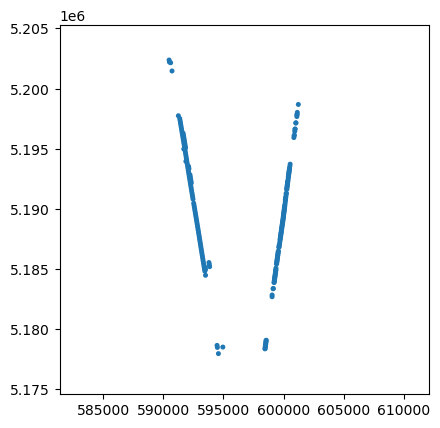

In [ ]:
#Zoom in, these are circles (buffered polygon around points)
ax = glas_gdf_utm_wa_buff.plot()
ax.set_xlim(581385.0, 612105.0)
ax.set_ylim(5174595.0, 5205315.0)

In [ ]:
#Define relevant stats for our sampling
stats=['count', 'min', 'max', 'median', 'std']

In [ ]:
#Compute zonal stats for buffered circles around each point using rasterstats
#Note: this could require a few minutes
#https://pythonhosted.org/rasterstats/rasterstats.html
glas_zonal_stats = rasterstats.zonal_stats(glas_gdf_utm_wa_buff, wa_ma, \
                                           affine=wa_ma_transform, nodata=src_proj.nodata, stats=stats)

In [ ]:
glas_zonal_stats[0:5]

[{'count': 0, 'min': None, 'max': None, 'median': None, 'std': None},
 {'count': 0, 'min': None, 'max': None, 'median': None, 'std': None},
 {'count': 0, 'min': None, 'max': None, 'median': None, 'std': None},
 {'min': -1.0,
  'max': 3.0,
  'count': 4,
  'std': 1.4142135623730951,
  'median': 1.0},
 {'min': -1.0,
  'max': 11.0,
  'count': 14,
  'std': 2.8437184624849117,
  'median': 1.5}]

In [ ]:
#Create a dataframe from the list of dict objects, using original index
glas_zonal_stats_df = pd.DataFrame(glas_zonal_stats, index=glas_gdf_utm_wa_buff.index)
glas_zonal_stats_df

,count,min,max,median,std
467,0,NaN,NaN,NaN,NaN
468,0,NaN,NaN,NaN,NaN
469,0,NaN,NaN,NaN,NaN
470,4,-1.0,3.0,1.0,1.414214
471,14,-1.0,11.0,1.5,2.843718
...,...,...,...,...,...
65068,0,NaN,NaN,NaN,NaN
65069,0,NaN,NaN,NaN,NaN
65070,0,NaN,NaN,NaN,NaN
65071,0,NaN,NaN,NaN,NaN


In [ ]:
glas_gdf_utm_wa['buff_med_vs_rio_sample'] = glas_gdf_utm_wa['dem_rio_sample'] - glas_zonal_stats_df['median']
glas_gdf_utm_wa['buff_med_std'] = glas_zonal_stats_df['std']

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

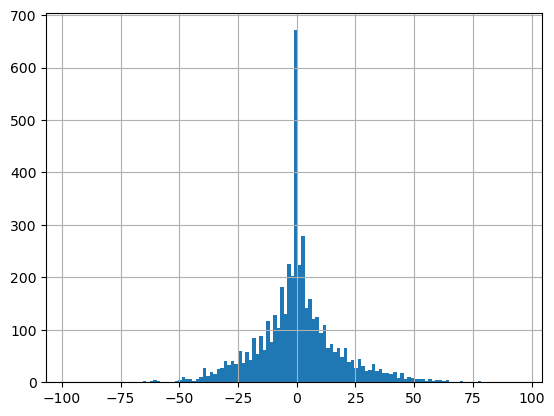

In [ ]:
glas_gdf_utm_wa['buff_med_vs_rio_sample'].hist(bins=128)

Text(0.5, 1.0, 'Buffered zonal stats std')

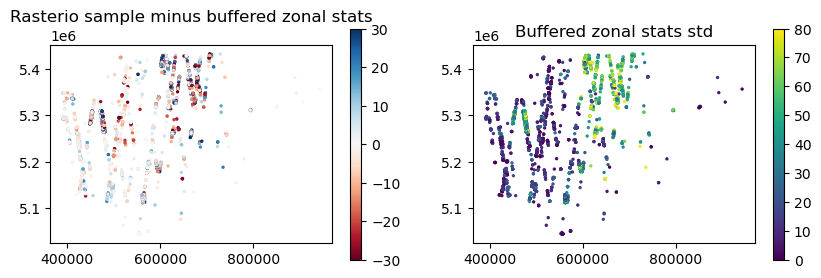

In [ ]:
f, axa = plt.subplots(1, 2, figsize=(10,3))
glas_gdf_utm_wa.plot(ax=axa[0], column='buff_med_vs_rio_sample', vmin=-30, vmax=30, cmap='RdBu', s=2, legend=True)
axa[0].set_title('Rasterio sample minus buffered zonal stats')
glas_gdf_utm_wa.plot(ax=axa[1], column='buff_med_std', s=2, vmin=0, vmax=80, legend=True);
axa[1].set_title('Buffered zonal stats std')

Greatest disagreement is over mountainous areas, where observed std within each ~420 m diameter sample is relatively high

#### Extra Credit: Do the GLAS points provide a good sample of the observed WA state hypsometry?
* Hypsometry is just total area in different elevation bins (https://en.wikipedia.org/wiki/Hypsometry)
* Plot histogram for your clipped WA DEM
* Plot the histogram of your glas sites on the same axes using the same bins

In [ ]:
#Student Exercise

## Part 4: Zonal Stats
### Which sections of WA highways are surrounded by the steepest slopes?
* Requires sampling a derived DEM product (slope) around Polyline objects (highways)
* This is important for geohazards (rockfall, avalanches)
* You can probably make an informed guess here based on knowledge of the terrain and WA highway network
* Note that in practice, you would want to higher resolution DEM with higher accuracy (e.g., DTM from airborne lidar), but same concept/method applies

### Compute surface slope
* Easy to use `gdaldem` command line utility here (like hillshade generation above) to create a new tif file with slope values
* Can also compute slope directly from our DEM array using `np.gradient`

In [ ]:
slope_fn = os.path.splitext(proj_fn)[0]+'_slope.tif'

In [ ]:
#Student Exercise

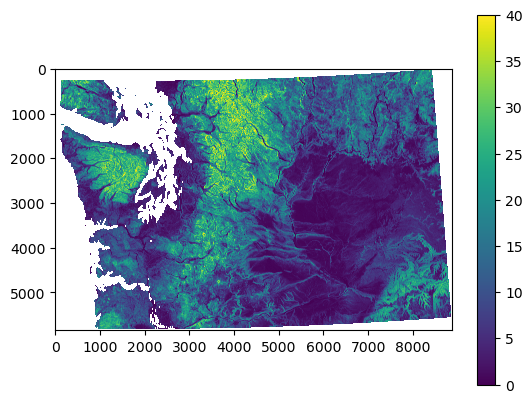

In [ ]:
#Student Exercise

### Prepare highway data
* We'll use some polyline data from Washington State Department of Transportation (WSDOT) here
* https://www.wsdot.wa.gov/mapsdata/geodatacatalog/maps/NOSCALE/DOT_TDO/LRS/sr500kjpg.htm

In [ ]:
from datetime import datetime
year = datetime.now().year - 2
#year = 2021

#Link to WA DOT highway data (requires updating each year)
#wa_dot_highway_url = 'https://data.wsdot.wa.gov/geospatial/DOT_TDO/LRS/Historic/500kLRS_2020.zip'
wa_dot_highway_url = f'https://data.wsdot.wa.gov/geospatial/DOT_TDO/LRS/500kLRS_{year}.zip'
#Relative path of the shapefile within the zip archive
wa_dot_highway_shp_fn = f'500k/sr500klines_{year}1231.shp'

#### Load the shapefile to GeoPandas GeoDataFrame
* We can do this on the fly!
* https://geopandas.readthedocs.io/en/latest/docs/user_guide/io.html#reading-and-writing-files

In [ ]:
#Open zip file and contained shapefile on-the-fly with GeoPandas
highways_gdf = gpd.read_file(f'zip+{wa_dot_highway_url}!{wa_dot_highway_shp_fn}')
highways_gdf_utm = highways_gdf.to_crs(src_proj.crs)

In [ ]:
highways_gdf.head()

,BARM,EARM,REGION,DISPLAY,RT_TYPEA,RT_TYPEB,LRS_Date,RouteID,StateRoute,RelRouteTy,RelRouteQu,SHAPE_STLe,geometry
0,212.81,213.46,EA,2,US,2,20211231,002,002,None,None,3413.387059,"LINESTRING (2077763.828 891111.197, 2077970.07..."
1,213.46,242.68,EA,2,US,2,20211231,002,002,None,None,154217.182705,"LINESTRING (2080916.017 889804.703, 2082959.44..."
2,242.68,243.47,EA,2,US,2,20211231,002,002,None,None,4116.114242,"LINESTRING (2217709.066 854913.089, 2219863.05..."
3,243.47,253.01,EA,2,US,2,20211231,002,002,None,None,50376.876336,"LINESTRING (2221786.174 855269.331, 2222649.58..."
4,253.01,255.89,EA,2,US,2,20211231,002,002,None,None,15290.597916,"LINESTRING (2271741.605 859012.973, 2277739.38..."


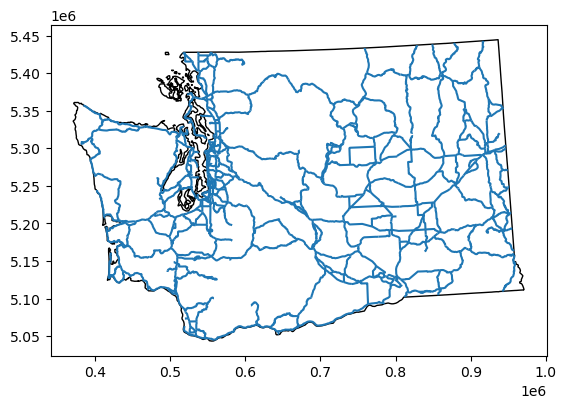

In [ ]:
f, ax = plt.subplots()
wa_state.plot(ax=ax, facecolor='none', edgecolor='k')
highways_gdf_utm.plot(ax=ax);

### Compute polygons for a 100 m buffer around the polylines
* Remember that the output of `buffer` is a GeoSeries of Polygons - want to create a new GeoDataFrame and use this as the `geometry`
* Plot as sanity check. Sample plot shows zoomed in region over I-5 and I-90 interchange, with original lines and buffered polygons in blue

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

### Now use `rasterstats.zonal_stats` to compute slope statistics within those polygons
* See the `rasterstats` documentation: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics
* The docs example uses a shapefile on disk and raster on disk, but we already have our features and raster loaded in memory!
    * Can pass in the GeoDataFrame containing buffered Polygon features instead of a filename
    * Can pass in the slope NumPy array instead of the raster filename, but need to provide the appropriate rasterio dataset `transform` to the `affine` keyword
        * Should also pass the appropriate rasterio dataset `nodata` value
* Compute stats and add the following columns to the `highways_gdf_utm` geodataframe for each highway segment:
    * mean slope
    * std of slope (a roughness metric)
* Create some plots to visualize
    * If you're plotting the GeoDataFrame containing the original LINESTRING geometry objects, choose an appropriate `linewidth`

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

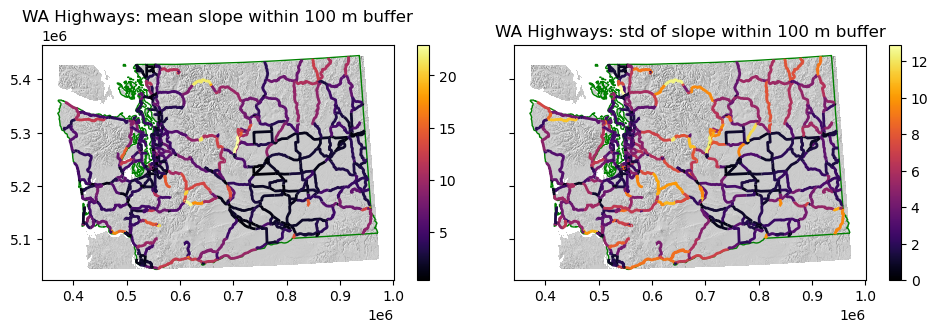

In [ ]:
#Student Exercise

### Which section of the highway might you close first during periods of extreme winter weather? ✍️

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

### Extra Credit
Try one or more of the following:
1. Explore different buffer widths - do your results change?
1. Compute zonal stats for the elevation values (not slope values)
    * Which highway sections cover the greatest elevation range?
1. Compute the slope _along_ the highway polylines, not zonal stats for slope of surrounding terrain
    * Probably want to sample your DEM at points here and compute rise (elevation change) over run (distance between points)
1. Repeat some of the above analysis for WA rivers or watersheds

### Extra Credit: explore some spatial functions with xarray-spatial
* We will cover xarray data model in a few weeks, but check out some of the raster/DEM functionality in this new package

### Extra Credit: explore some hydrologic functions with RichDEM
* https://github.com/r-barnes/richdem